## About

This notebook compares $R_e$ distributions for the Holla et al. (Schuler) IDR sequences. Specifically, it compares histograms of end-to-end distances obtained from STARLING with inter-dye distances measured experimentally. We also compare the correlation between experiment and STARLING, and $R_g$ vs. $R_e$.

Specifically, the concordance_correlation_coefficient is used here (and not used elsewhere) and calculated as:

$
\rho_c = \frac{2 \sigma_{xy}}
               {\sigma_x^2 + \sigma_y^2 + (\mu_x - \mu_y)^2}
\$

## References

Holla, A., Martin, E. W., Dannenhoffer-Lafage, T., Ruff, K. M., König, S. L. B., Nüesch, M. F., Chowdhury, A., Louis, J. M., Soranno, A., Nettels, D., Pappu, R. V., Best, R. B., Mittag, T. & Schuler, B. Identifying sequence effects on chain dimensions of disordered proteins by integrating experiments and simulations. JACS Au 4, 4729–4743 (2024).
  



In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# Major and minor tick widths
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['ytick.major.width'] = 0.5
matplotlib.rcParams['xtick.minor.width'] = 0.5
matplotlib.rcParams['ytick.minor.width'] = 0.5


# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from afrc import AnalyticalFRC
from sparrow import Protein
from shephard import interfaces, apis

from scipy.signal import savgol_filter
import metapredict as meta
from sparrow.data.amino_acids import VALID_AMINO_ACIDS
import pandas as pd
from scipy.stats import spearmanr
from soursop.sstrajectory import SSTrajectory
from starling import load_ensemble


In [2]:
import numpy as np

def concordance_correlation_coefficient(y_true, y_pred):
    """
    Compute the Concordance Correlation Coefficient (CCC) between two arrays.

    The Concordance Correlation Coefficient evaluates the degree to which pairs of
    observations fall on the 45-degree line through the origin. It combines measures
    of both precision (Pearson correlation) and accuracy (closeness to the identity line),
    making it useful for assessing agreement between predicted and true values.

    Parameters
    ----------
    y_true : array_like
        Ground truth (true) values.
    y_pred : array_like
        Predicted values.

    Returns
    -------
    ccc : float
        Concordance Correlation Coefficient between `y_true` and `y_pred`.
        The coefficient ranges from -1 to 1:
        - 1 indicates perfect concordance,
        - 0 indicates no concordance,
        - -1 indicates perfect discordance.

    Notes
    -----
    The CCC is defined as:

    .. math::

        \\rho_c = \\frac{2 \\sigma_{xy}}
                        {\\sigma_x^2 + \\sigma_y^2 + (\\mu_x - \\mu_y)^2}

    where:
        - \\( \\mu_x \\) and \\( \\mu_y \\) are the means of `y_true` and `y_pred`,
        - \\( \\sigma_x^2 \\) and \\( \\sigma_y^2 \\) are their variances,
        - \\( \\sigma_{xy} \\) is the covariance between them.

    This metric is often used in regression tasks where agreement is more important than
    simple correlation.

    Examples
    --------
    >>> import numpy as np
    >>> from mymodule import concordance_correlation_coefficient
    >>> y_true = np.array([1.0, 2.0, 3.0])
    >>> y_pred = np.array([1.1, 1.9, 3.2])
    >>> concordance_correlation_coefficient(y_true, y_pred)
    0.986...

    References
    ----------
    
    Lin, L. I. A concordance correlation coefficient to evaluate reproducibility. Biometrics 45, 255–268 (1989).
  
    """
    # Calculate means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Calculate variances
    var_true = np.var(y_true, ddof=0)
    var_pred = np.var(y_pred, ddof=0)
    
    # Calculate covariance
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    
    # Numerator and denominator of CCC
    numerator = 2 * covariance
    denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
    
    # Compute CCC
    ccc = numerator / denominator
    return ccc



In [3]:
from sparrow import Protein
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import protfasta

from scipy.stats import spearmanr


def calc_rmse(d1,d2):    
    """
    Function that given two lists or vectors, calculates the root-mean-square error (RMSE)
    between the two input datasets. Assumes both are the same length
    
    Parameters
    -------------
    d1 : list/vector/np.ndarray
        Dataset 1

    d2 : list/vector/np.ndarray
        Dataset 2
        
    Returns
    -------------
    float
        Returns a float which is the RMSE between the two datasets
        

    """
    
    return np.sqrt(np.mean(np.power(np.array(d1) - np.array(d2),2)))

# define the sequences
seqs = {}
seqs['sGrich']    = 'GSGSCSGGYGSERGGGYGSERGGGYGSERGGGYGSERGGGYGSQRSGGGYGGSQRSSYGSGSCTLGPR'
seqs['dKh']       = 'GSGSCAMGGGPGPGTDFTSDQADFPDTLFQEFEPPAPRPGLAGGRPGDAALLSAAYGRRRLLCTLGPR'
seqs['dGrich']    = 'GSGSCGPRTGLEGAGMAGGSGQQKRVFDGQSGPQDLGEAYRPLNHDGGDGGNRYSVIDRIQECTLGPR'
seqs['sPTBP']     = 'GSGSCRPDLPSGDSQPSLDQTMAAAFGLSVPNVHGALAPLAIPSAAAAAAAAGRIAIPGLAGCTLGPR'
seqs['sCh']       = 'GSGSCKKAQPEMNDKDDNESGNEDAEENHDDEEDENEEEDRQVDQASKNKESKRKAQNKREDCTLGPR'
seqs['sNrich']    = 'GSGSCLDQEDNNGPLLIKTANNLIQNNSNMLPLNALHNAPPMHLNEGGISNMRVNDSLPSNTCTLGPR'
seqs['sKh']       = 'GSGSCKPRRLSKLRRSKKPADEENNAASQDPTVEATQERGQASEDPENAANNAKQAKPTSDDCTLGPR'
seqs['dCh_plus']  = 'GSGSCQTPLKRIKVKTPGKSGAAAREGSVVSGTDGPTQTGKPERRKRLNPPKDKLIDMDDADCTLGPR'
seqs['dCh_minus'] = 'GSGSCMGLPTGMEEKEEGTDESEQKPVVQTPAQPDDSAEVDSAALDQAESAKQQGPILTKHGCTLGPR'
seqs['sKl']       = 'GSGSCAPEGVFKLPAPPKEIKKSEKSEKSSDSSNDKKEVESTTKTAATTTTTKKGTDNNTQFCTLGPR'
seqs['sNh_plus']  = 'GSGSCPEEIETRKKDRKNRREMLKRTSALQPAAPKPTHKKPVPKRNVGAERKSTINEDLLPPCTLGPR'
seqs['dArich']    = 'GSGSCLPTGAEGRDSSKGEDSAEETEAKPAVVAPAPVVEAVSTPSAAFPSDATAEQGPILTKCTLGPR'
seqs['dErich']    = 'GSGSCEGEMFGVMCEENSVVLSVEQPAELKEVADVSPPPTTRNHTIEMKPPLSAQQSECNPVCTLGPR'
seqs['dTRBP']     = 'GSGSCLEPALEDSSSFSPLDSSLPEDIPVFTAAAAATPVPSVVLTRSPPMELQPPVSPQQSECTLGPR'
seqs['dKl']       = 'GSGSCLPTGMDQKTTELMKVDEPVSTQETLPPVIKMEPEPVPITETPTDENARQQGPILTKHCTLGPR'
seqs['sNh_minus'] = 'GSGSCKKKLQDTPSEPMEKDPAEPETVPDGETPEDENPTEEGADNSSAKMEEEEEEEEEEEECTLGPR'

schuler_colors = {}
schuler_colors['sGrich'] = '#989898'
schuler_colors['dKh'] = '#AE8150'
schuler_colors['dGrich'] = '#989833'
schuler_colors['sPTBP'] = '#429797'
schuler_colors['sCh'] = '#BBFECE'
schuler_colors['sNrich'] = '#C9F73D'
schuler_colors['sKh'] = '#333391'
schuler_colors['dCh_plus'] = '#7187DE'
schuler_colors['dCh_minus'] = '#69F2F1'
schuler_colors['sNh_plus'] = '#EACBFE'
schuler_colors['sKl'] = '#A64BC2'
schuler_colors['dArich'] = '#F25AEA'
schuler_colors['dErich'] = '#FBCBCB'
schuler_colors['dTRBP'] = '#EA476F'
schuler_colors['dKl'] = '#F69A5A'
schuler_colors['sNh_minus'] = '#FEE648'

albatross_re = {}
for s in seqs:
    albatross_re[s] = Protein(seqs[s]).predictor.end_to_end_distance()


all_new_vals = {
    "sGrich": {"re": 4.0, "nu": 0.47},
    "dKh": {"re": 4.7, "nu": 0.51},
    "dGrich": {"re": 5.1, "nu": 0.53},
    "sPTBP": {"re": 5.5, "nu": 0.55},
    "sCh": {"re": 5.7, "nu": 0.56},
    "sNrich": {"re": 5.9, "nu": 0.56},
    "sKh": {"re": 5.9, "nu": 0.57},
    "dCh_plus": {"re": 5.9, "nu": 0.57},
    "dCh_minus": {"re": 6.7, "nu": 0.59},
    "sKl": {"re": 6.7, "nu": 0.59},
    "sNh_plus": {"re": 6.7, "nu": 0.59},    
    "dArich": {"re": 6.8, "nu": 0.60},
    "dErich": {"re": 6.9, "nu": 0.60},
    "dTRBP": {"re": 7.1, "nu": 0.61},
    "dKl": {"re": 7.2, "nu": 0.61},
    "sNh_minus": {"re": 7.3, "nu": 0.61}
}

new_vals = {}
for k in all_new_vals: 
    new_vals[k] = all_new_vals[k]['re']


Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


## Load SAXS data
Load SAXS data

In [4]:
saxs_rg_values = {}
starling_rg_values_mff = {}

# rg values here from analyzing scattering curves using the MFF of Riback et al. 2017
for n in ['sNrich', 'sNh_plus', 'dCh_minus', 'dTRBP']:
    saxs_rg_values[n] = float(np.loadtxt(f'saxs/{n}/mff_rg_{n}.csv'))
    starling_rg_values_mff[n] = float(np.loadtxt(f'saxs/{n}/mff_rg_{n}.csv'))


In [5]:
WRITE_FASTA = False
if WRITE_FASTA:
    protfasta.write_fasta(seqs,'schuler_seqs.fasta')

In [6]:
starling_ensembles = {}
starling_res = {}
starling_rgs = {}
starling_res_all = {}
starling_rgs_all = {}

fret_values = []
for k in seqs:
    e = load_ensemble(f'ensembles//{k}.starling')
    starling_res[k] = e.end_to_end_distance(return_mean=True)
    starling_rgs[k] = e.radius_of_gyration(return_mean=True)
    starling_res_all[k] = e.end_to_end_distance()
    starling_rgs_all[k] = e.radius_of_gyration()
    fret_values.append(all_new_vals[k]['re']*10)

fret_values = np.array(fret_values)
starling_mean_rg = np.array(list(starling_rgs.values()))
starling_mean_re = np.array(list(starling_res.values()))

Expected Re/Rg ratio : 2.45
Actual Re/Rg ratio   : 2.38


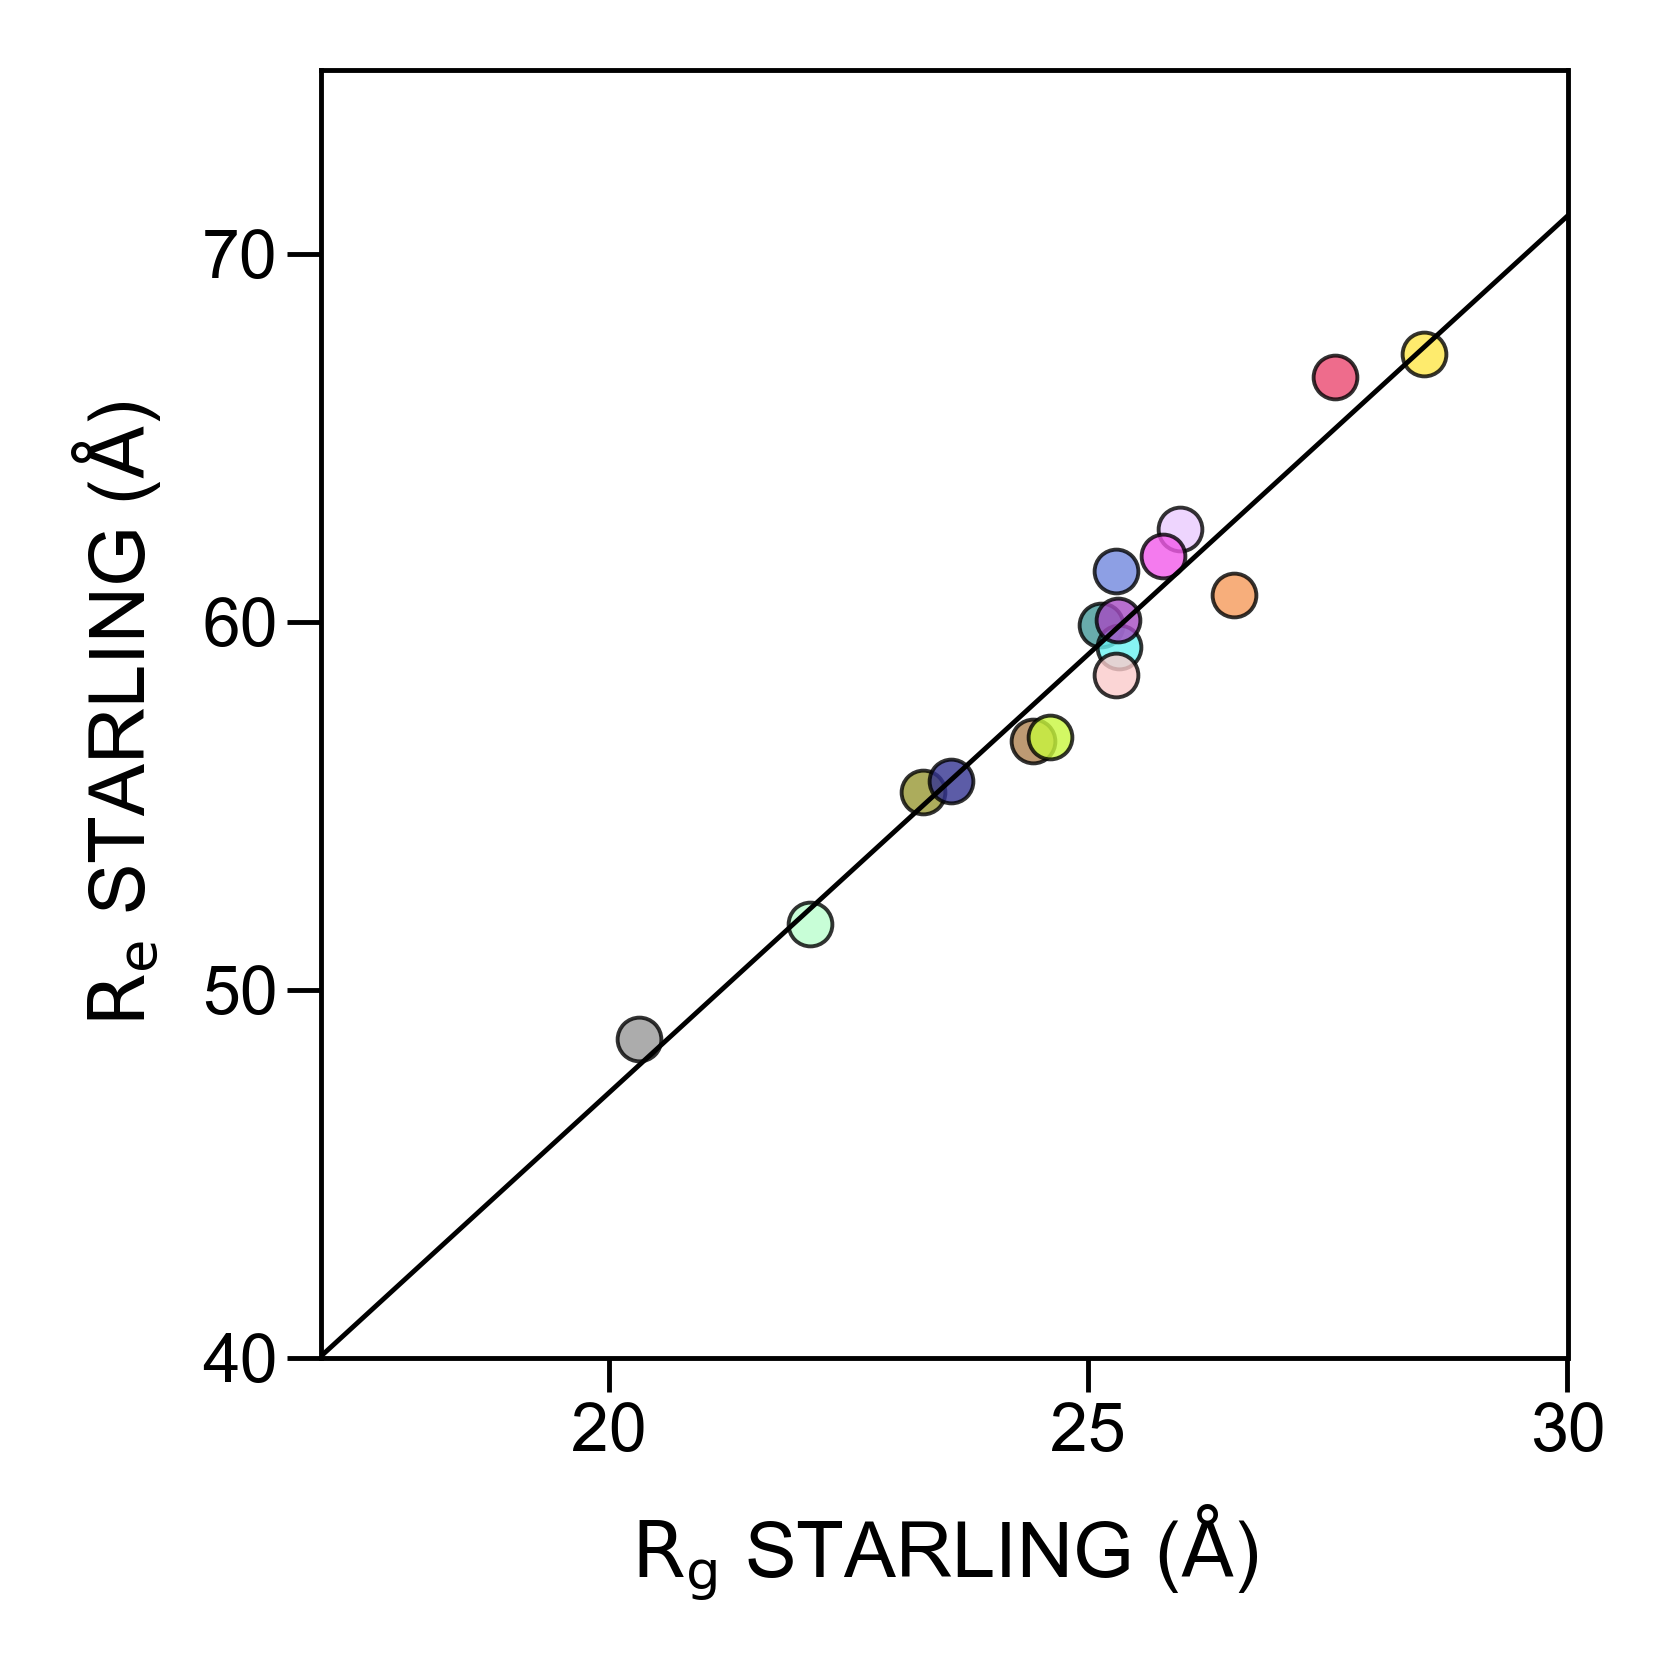

In [7]:
figure(None, (2.5,2.5), dpi=350)

for i, k in enumerate(all_new_vals):
    plt.plot(starling_rgs[k], starling_res[k], 'o', color=schuler_colors[k], ms=4.5, mew=0.4, alpha=0.8, mec='k', label='STARLING')


plt.xlabel(r'$\rm{R_g}$ STARLING ($\rm\AA$)', fontsize=8)
plt.ylabel(r'$\rm{R_e}$ STARLING ($\rm\AA$)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.xlim([17,30])
plt.ylim([40,75])    


linfit = np.polyfit(starling_mean_rg, starling_mean_re,1)
#plt.plot(np.arange(10,30), np.sqrt(6)*np.arange(10,30), color='r', ls='-', lw=0.5)

print(f"Expected Re/Rg ratio : {round(np.sqrt(6),2)}")
print(f"Actual Re/Rg ratio   : {round(linfit[0],2)}")

plt.plot(np.arange(10,40), linfit[0]*np.arange(10,40)+linfit[1], color='k', ls='-', lw=0.5)
plt.tight_layout()
plt.savefig('figures/rg_vs_re_starling.pdf')

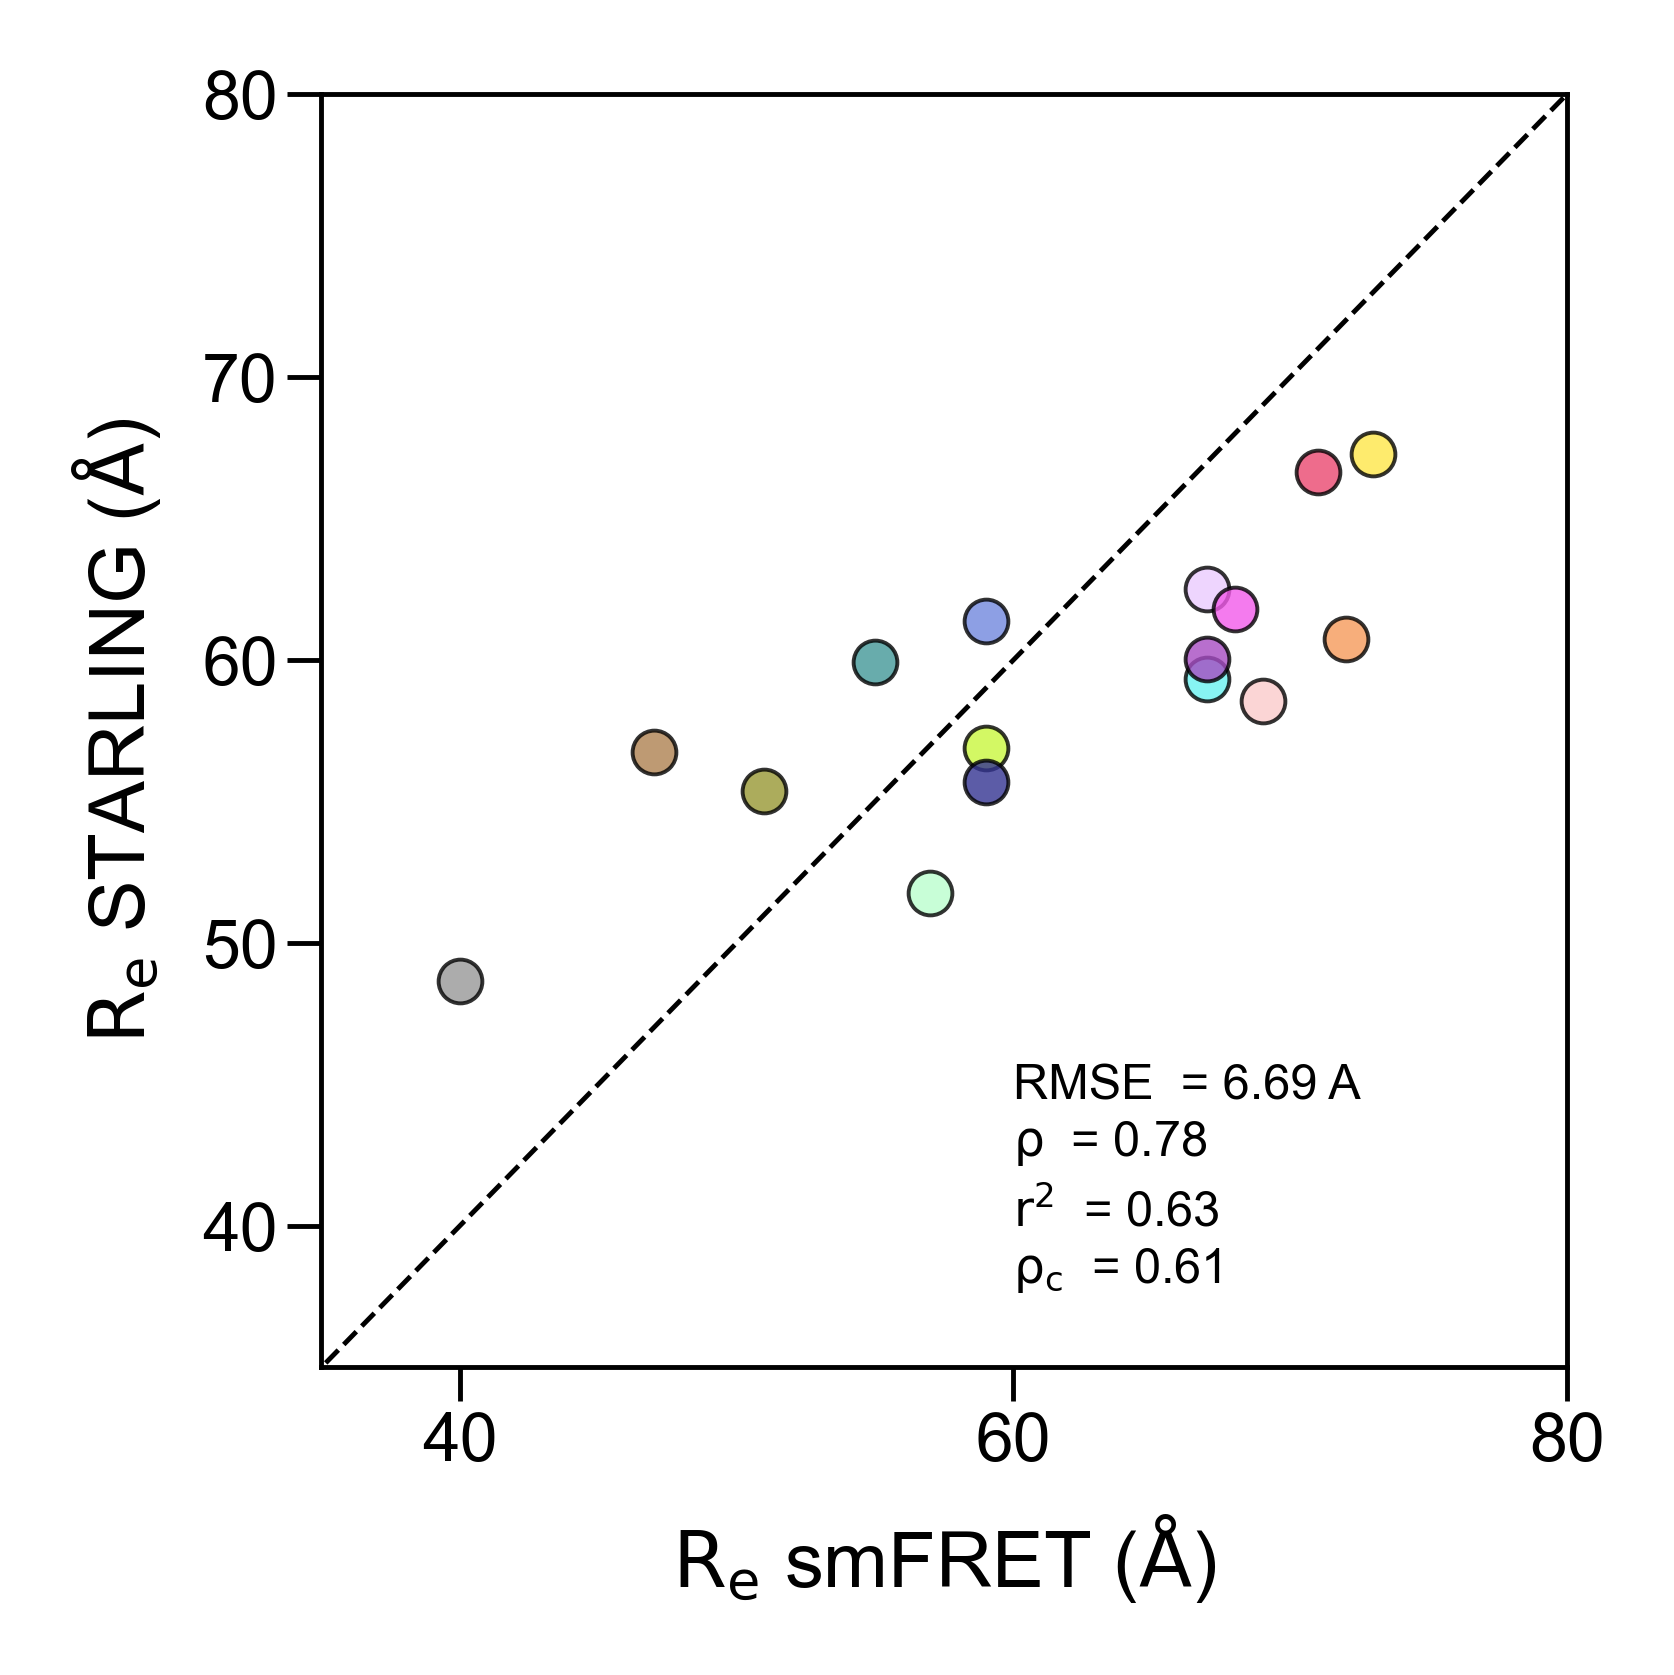

In [8]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

for i, k in enumerate(all_new_vals):
    plt.plot(fret_values[i], starling_mean_re[i], 'o', color=schuler_colors[k], ms=4.5, mew=0.4, alpha=0.8, mec='k', label='STARLING')

plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(fret_values, starling_mean_re)[0][1],2)
spearman_corr, p_value = spearmanr(fret_values, starling_mean_re)     

ccc = concordance_correlation_coefficient(fret_values, starling_mean_re)
plt.text(60, 38, r"$\rm{\rho_c}$ " +f" = {round(ccc,2)}", fontsize=5)
plt.text(60, 40, r"$\rm{r^2}$ " +f" = {round(r2,2)}", fontsize=5)
plt.text(60, 42.5, r"$\rm{\rho}$ " +f" = {round(spearman_corr,2)}", fontsize=5)
plt.text(60, 44.5, r"RMSE " +f" = {round(calc_rmse(fret_values,starling_mean_re),2)} A", fontsize=5)


plt.xlabel(r'$\rm{R_e}$ smFRET ($\rm\AA$)', fontsize=8)
plt.ylabel(r'$\rm{R_e}$ STARLING ($\rm\AA$)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.ylim([35,80])
plt.xlim([35,80])

plt.tight_layout()
plt.savefig('figures/STARLING_vs_smFRET.pdf')



# Plot distribution vs. actual value

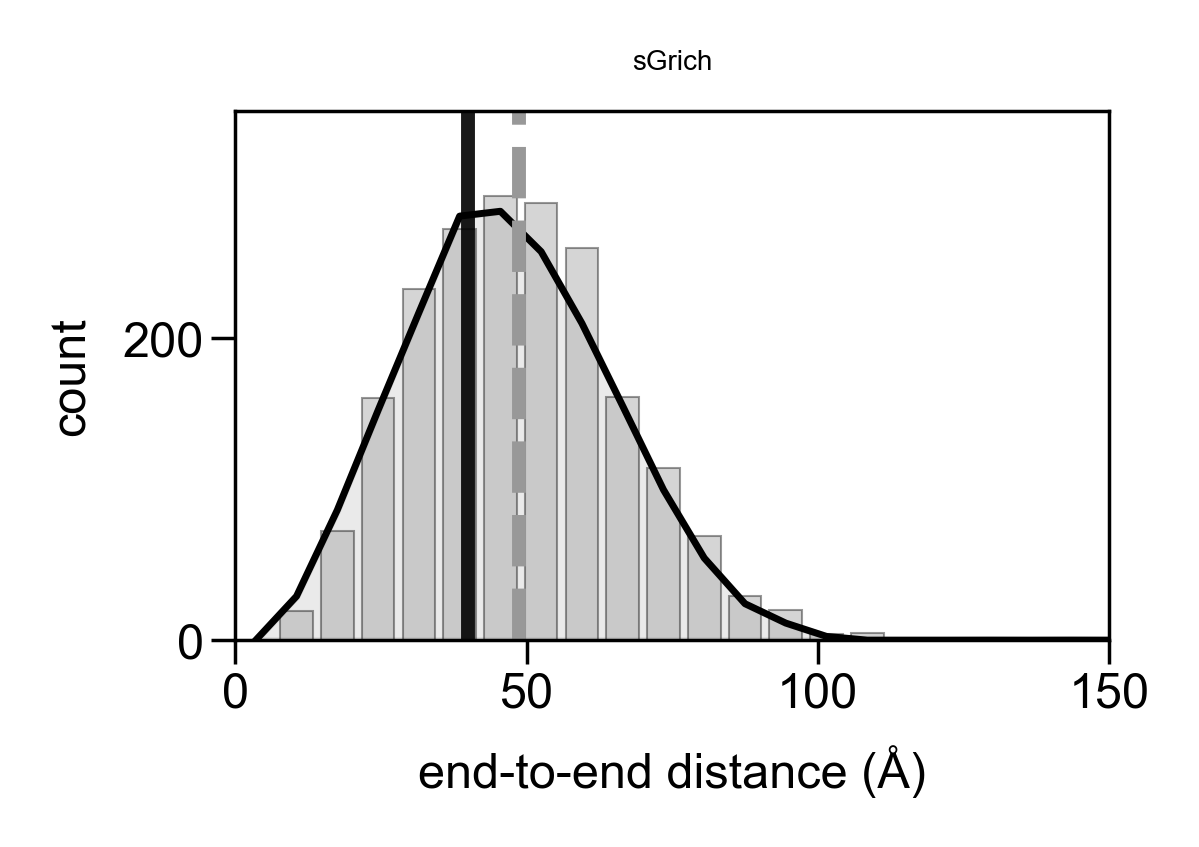

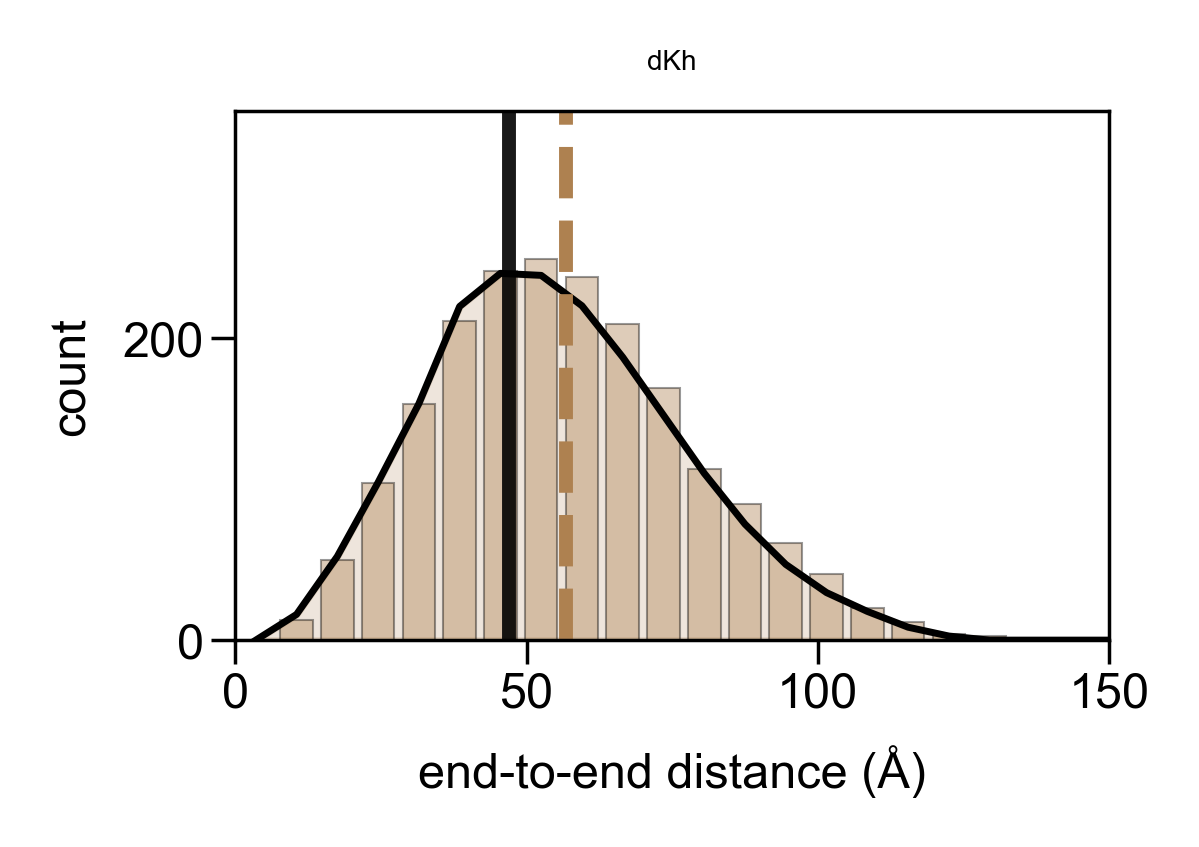

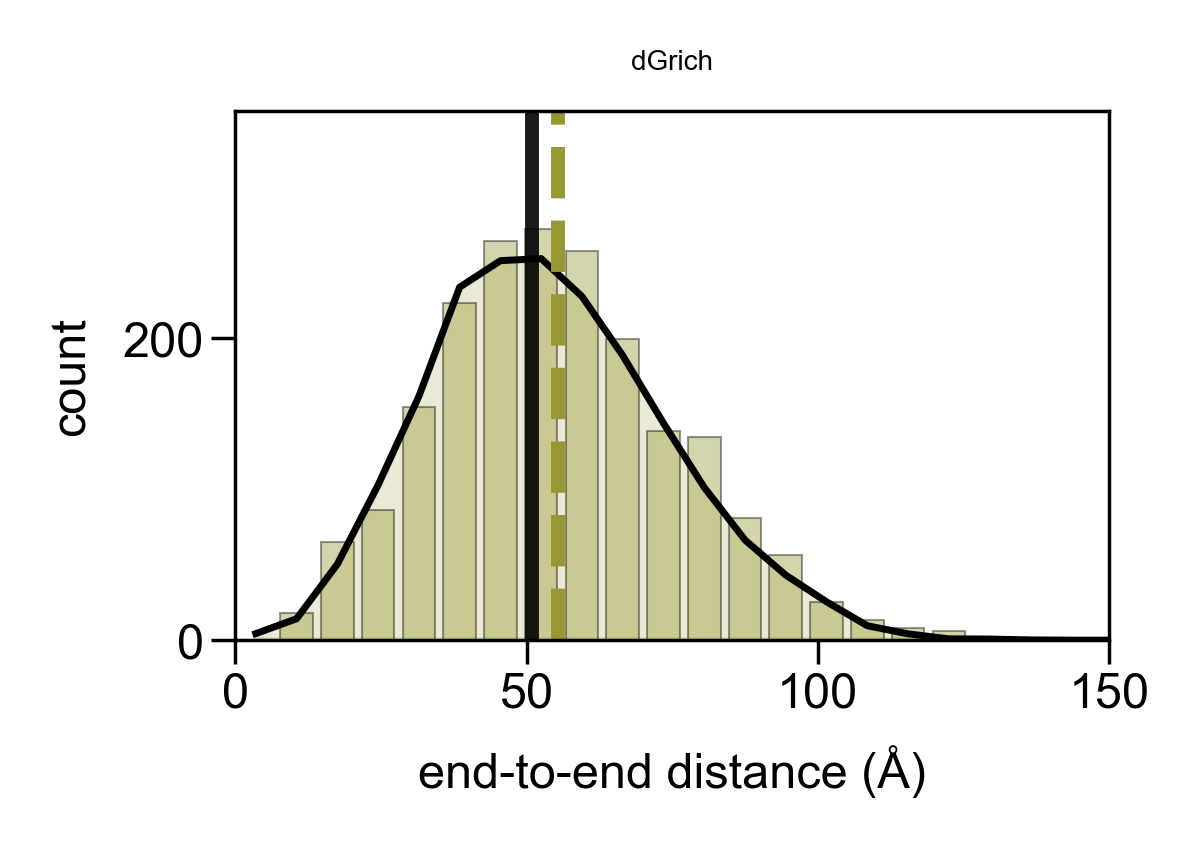

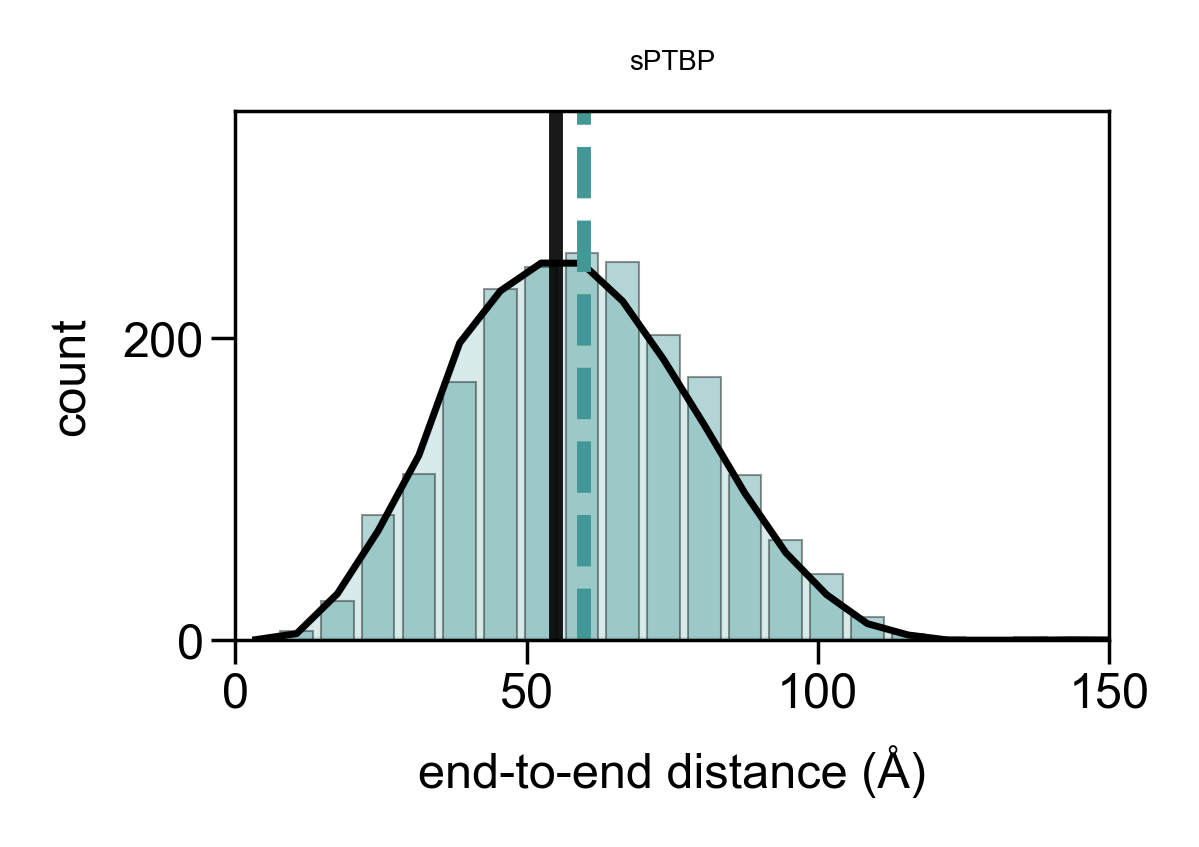

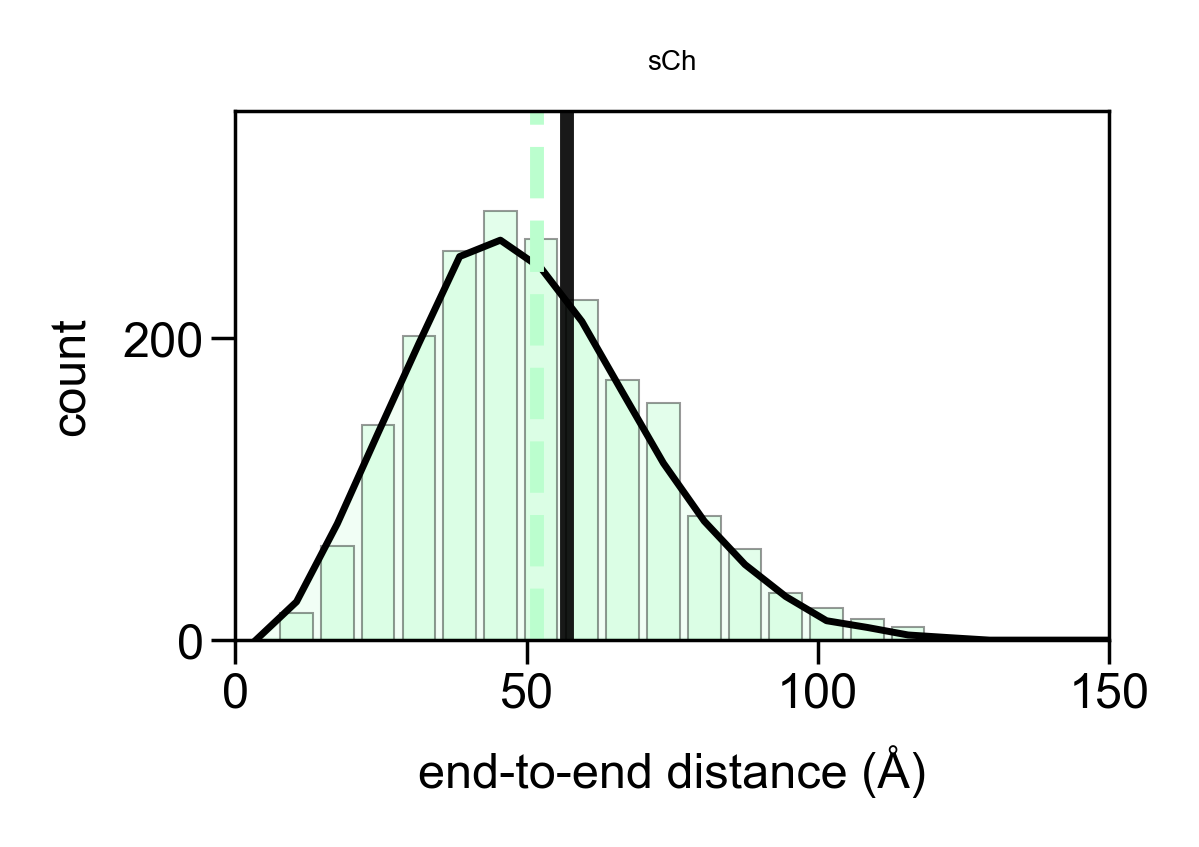

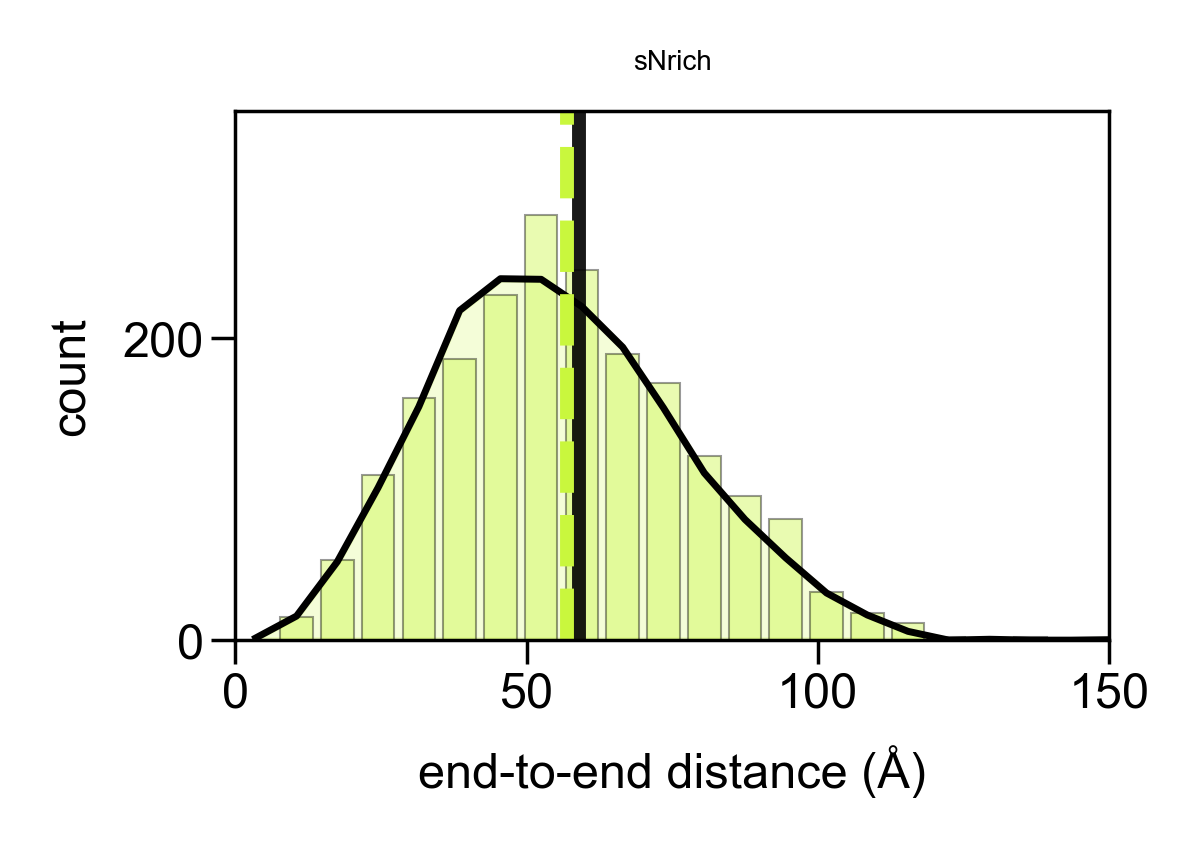

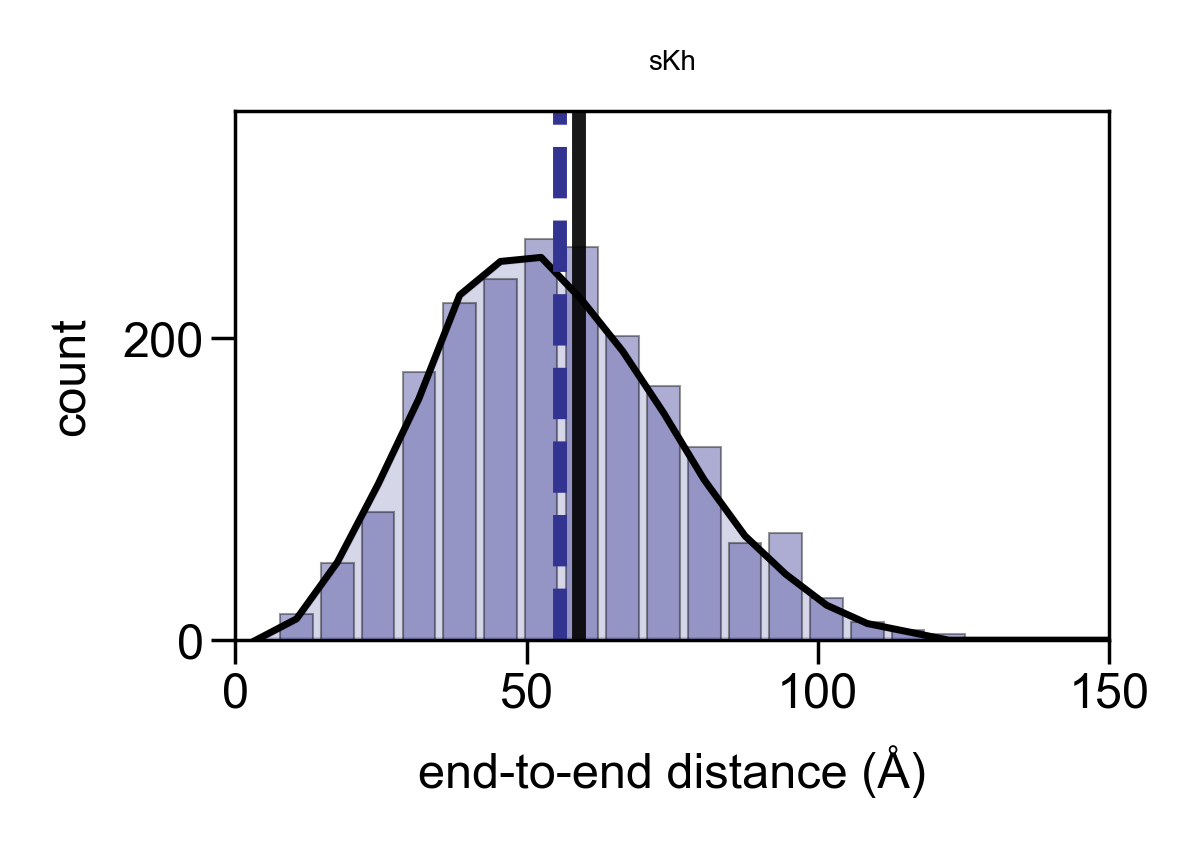

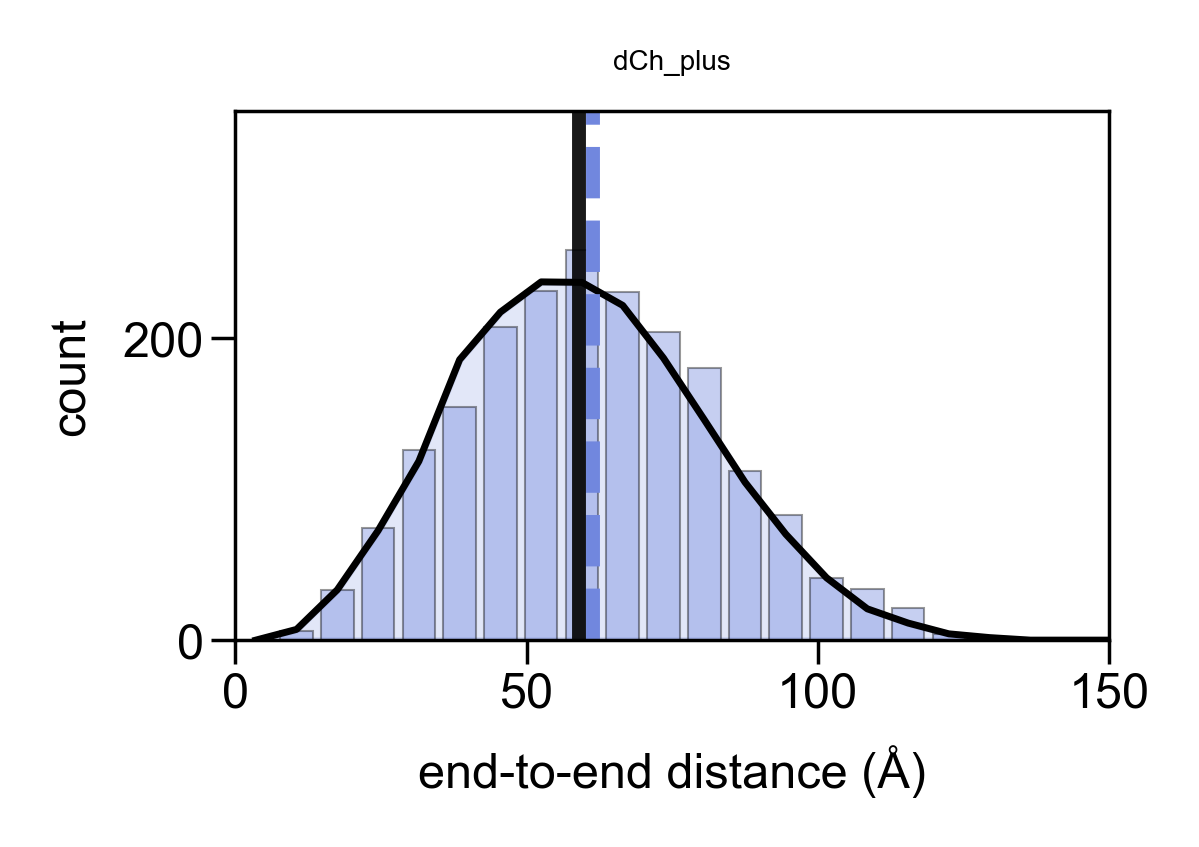

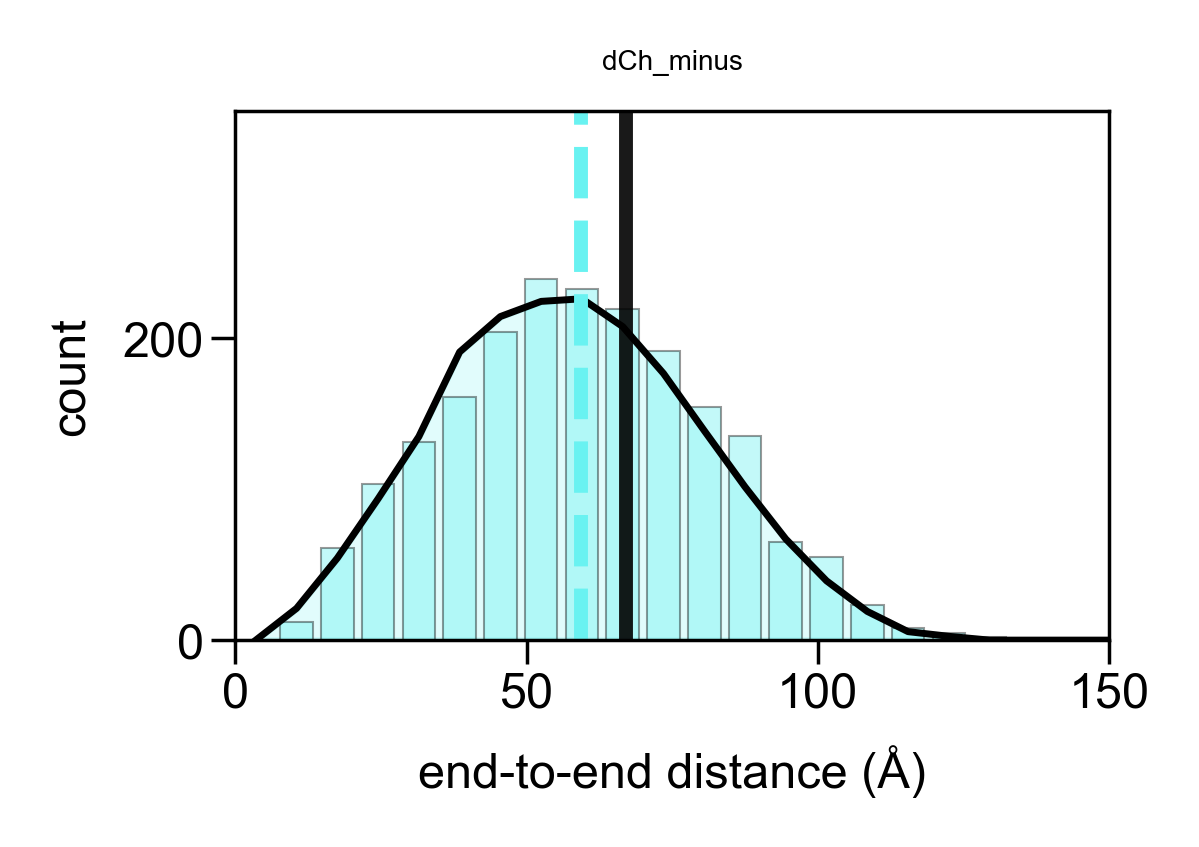

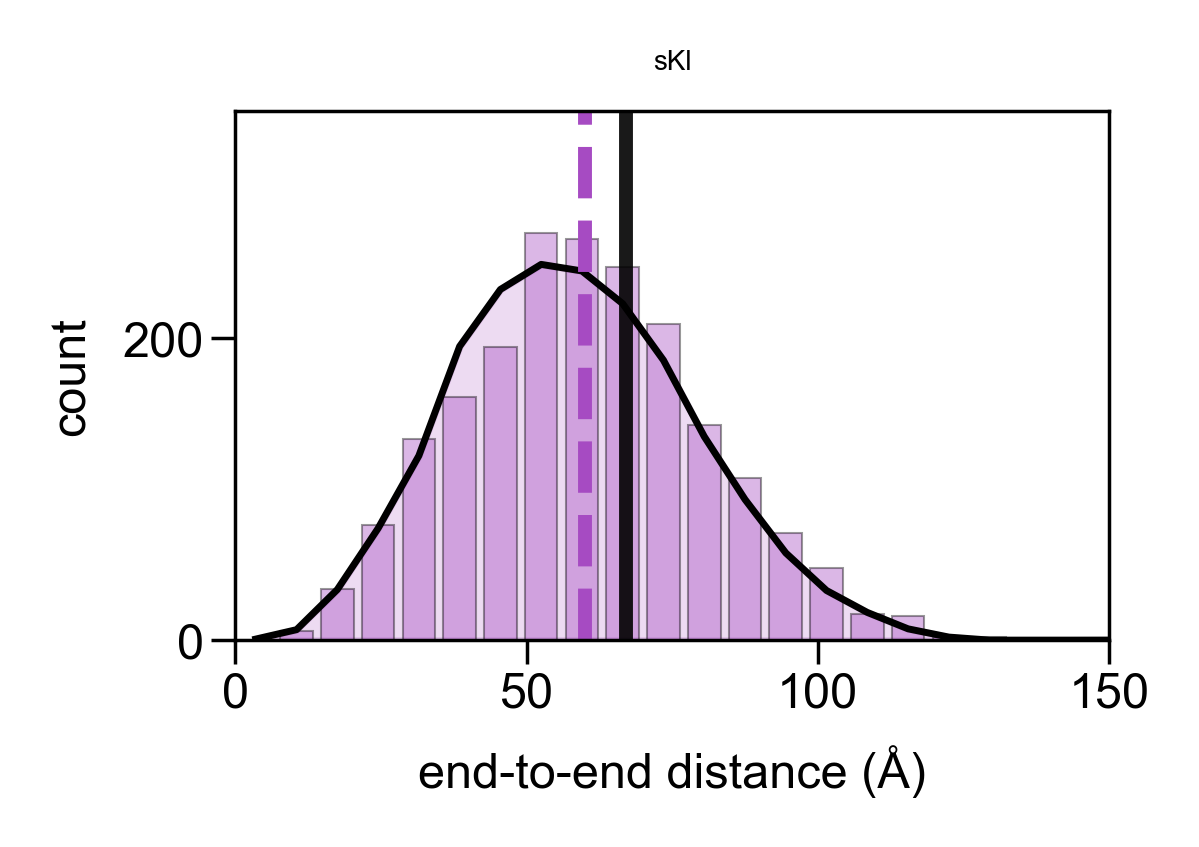

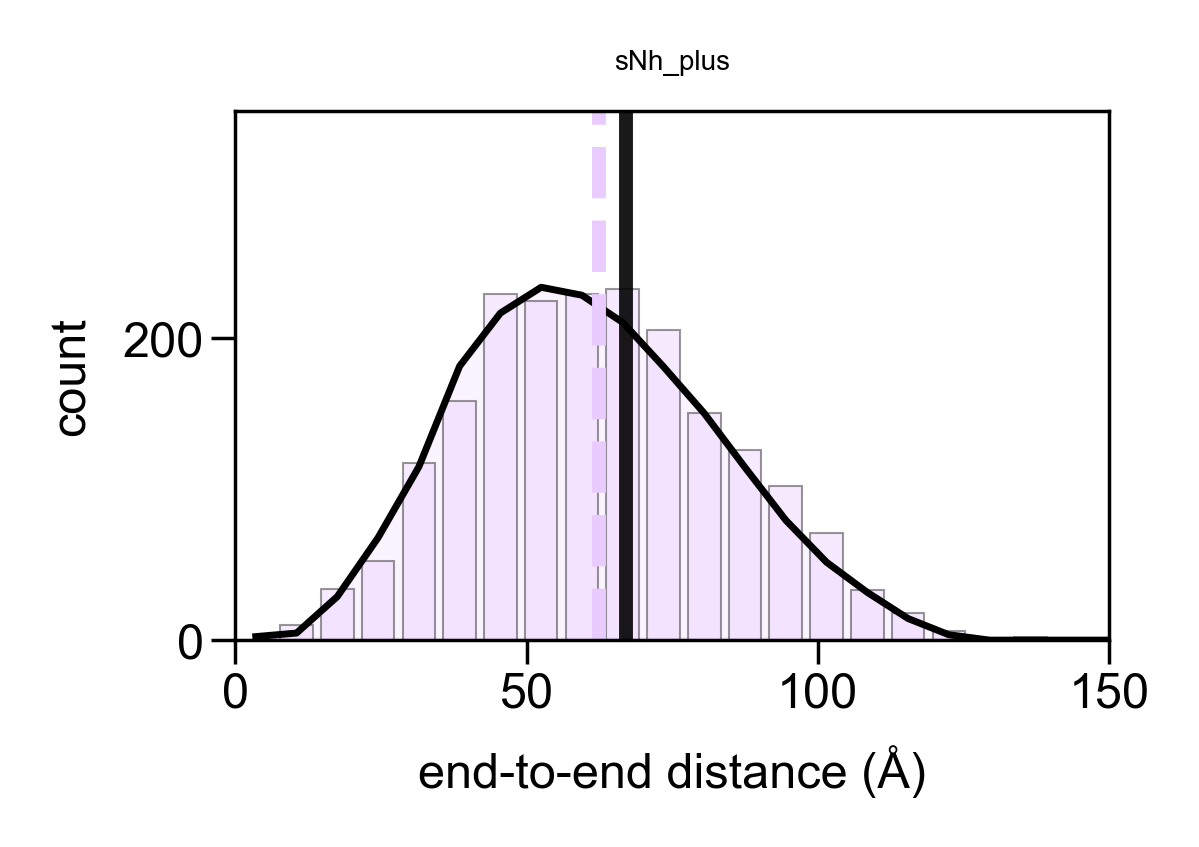

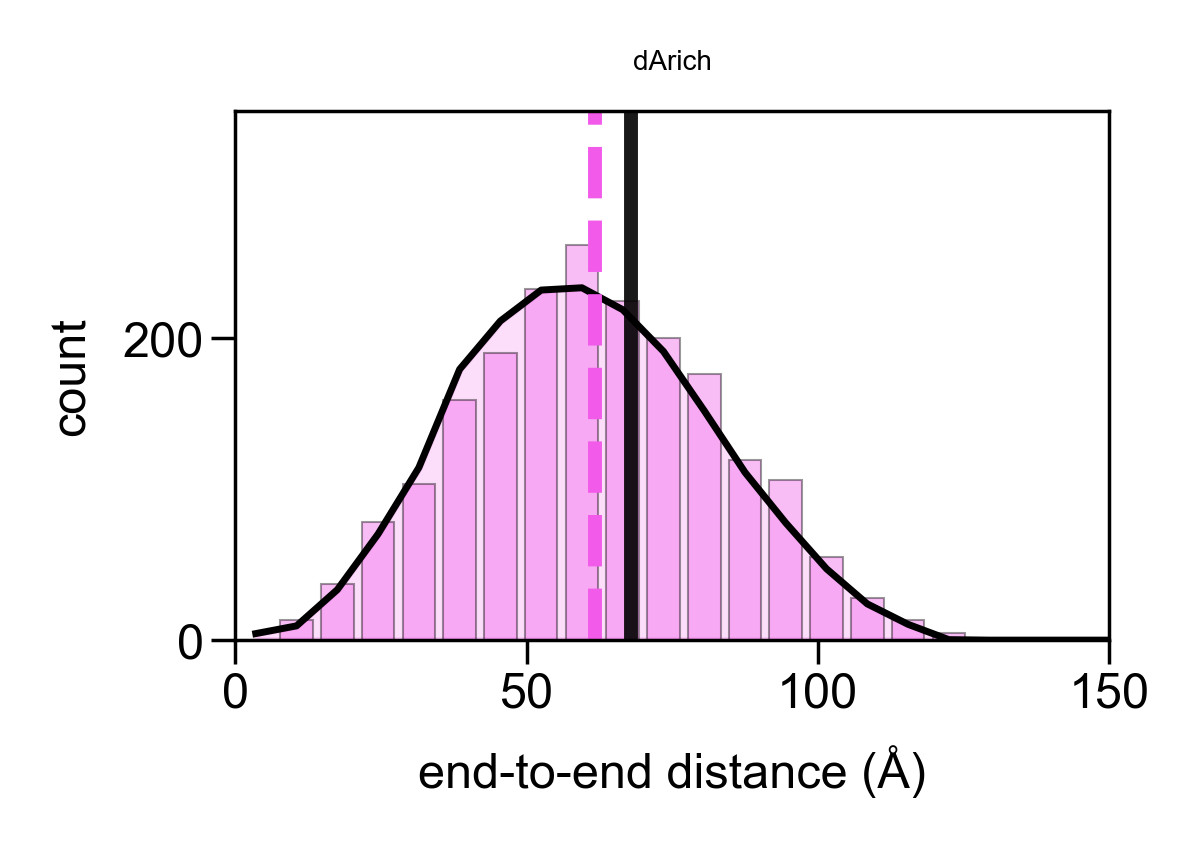

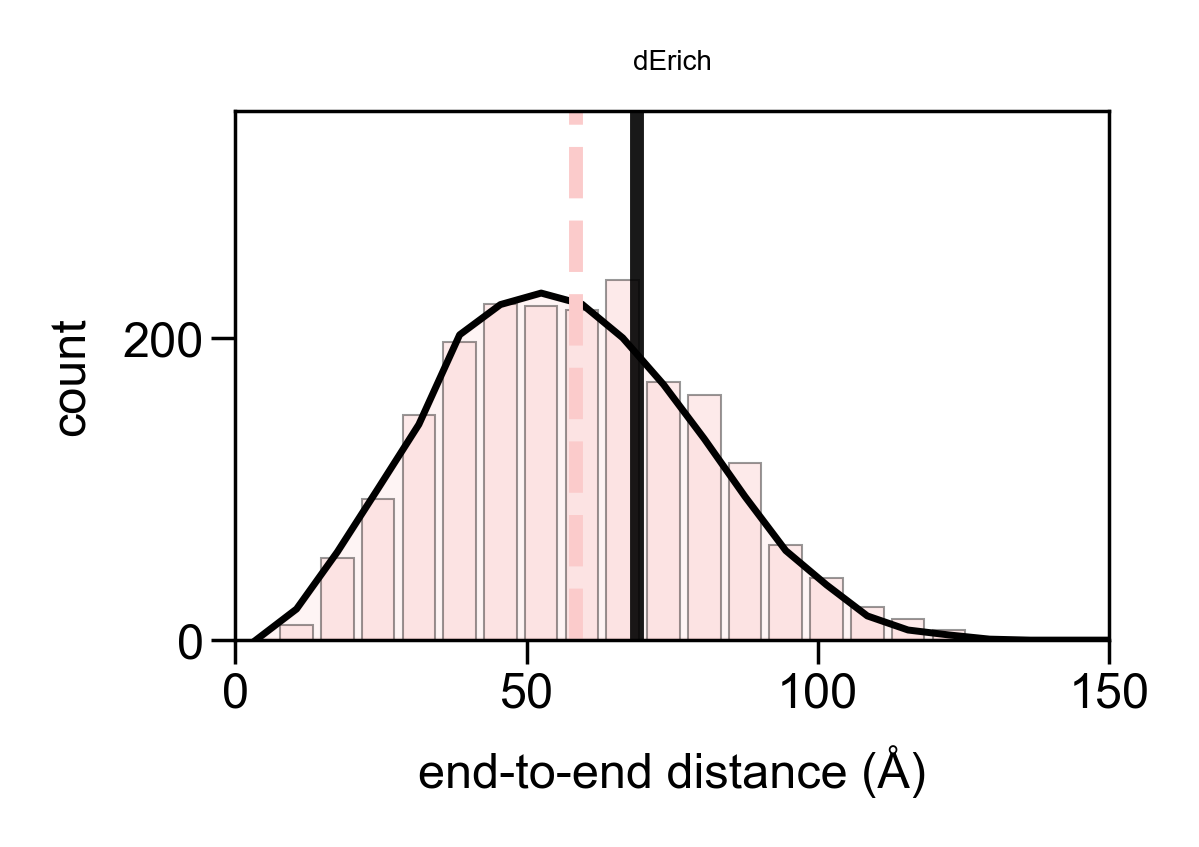

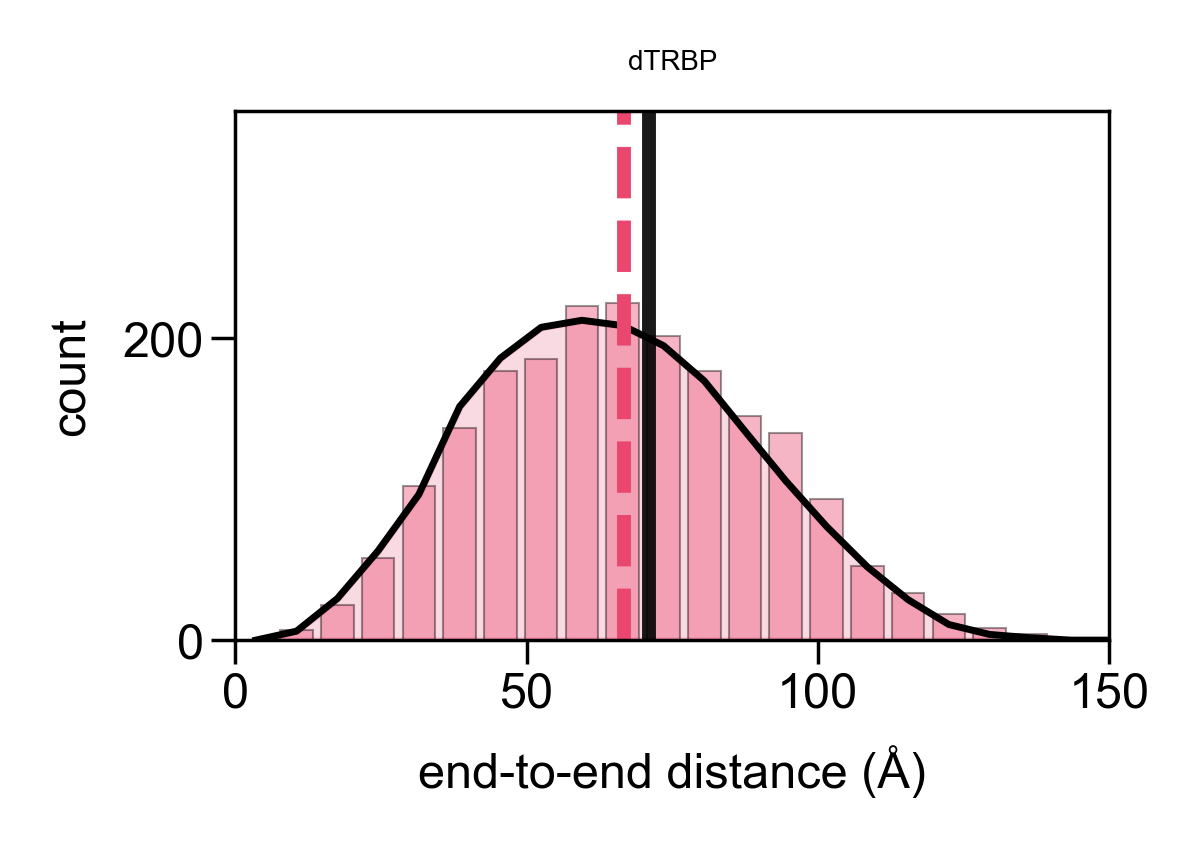

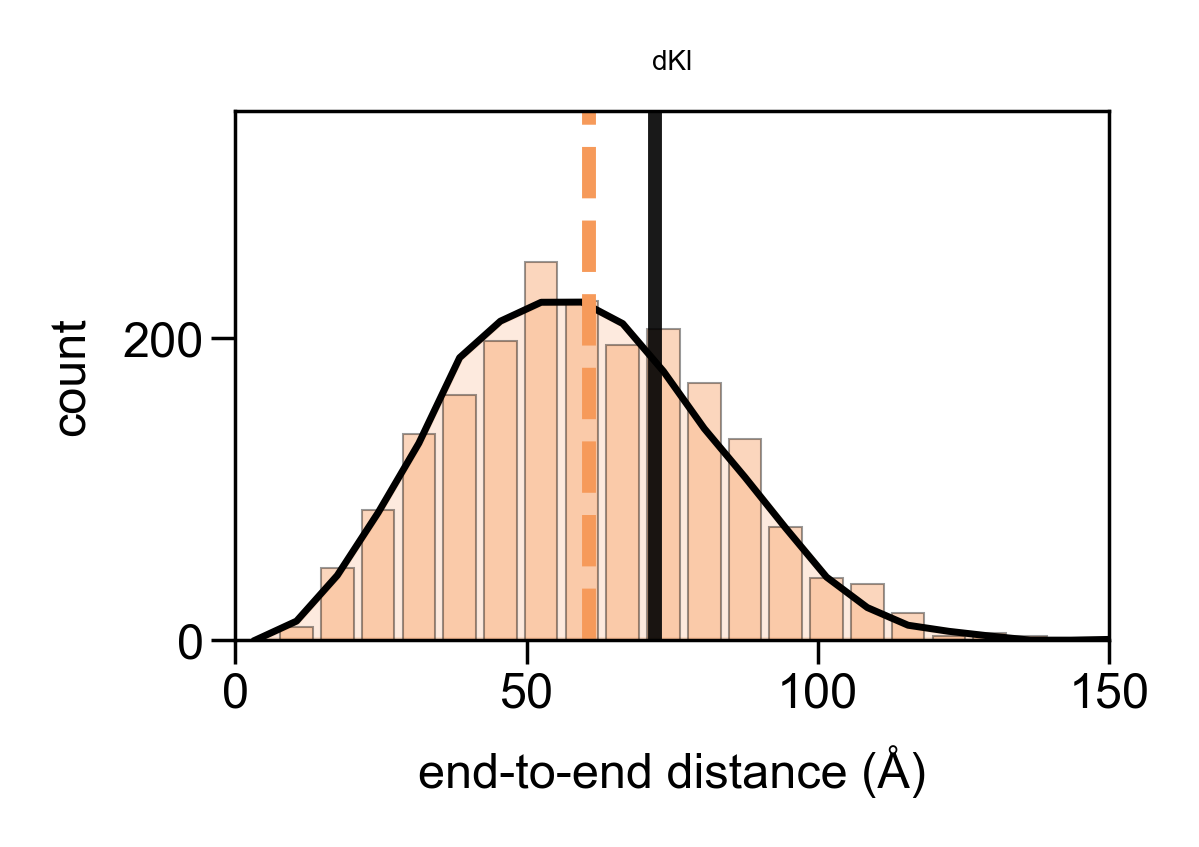

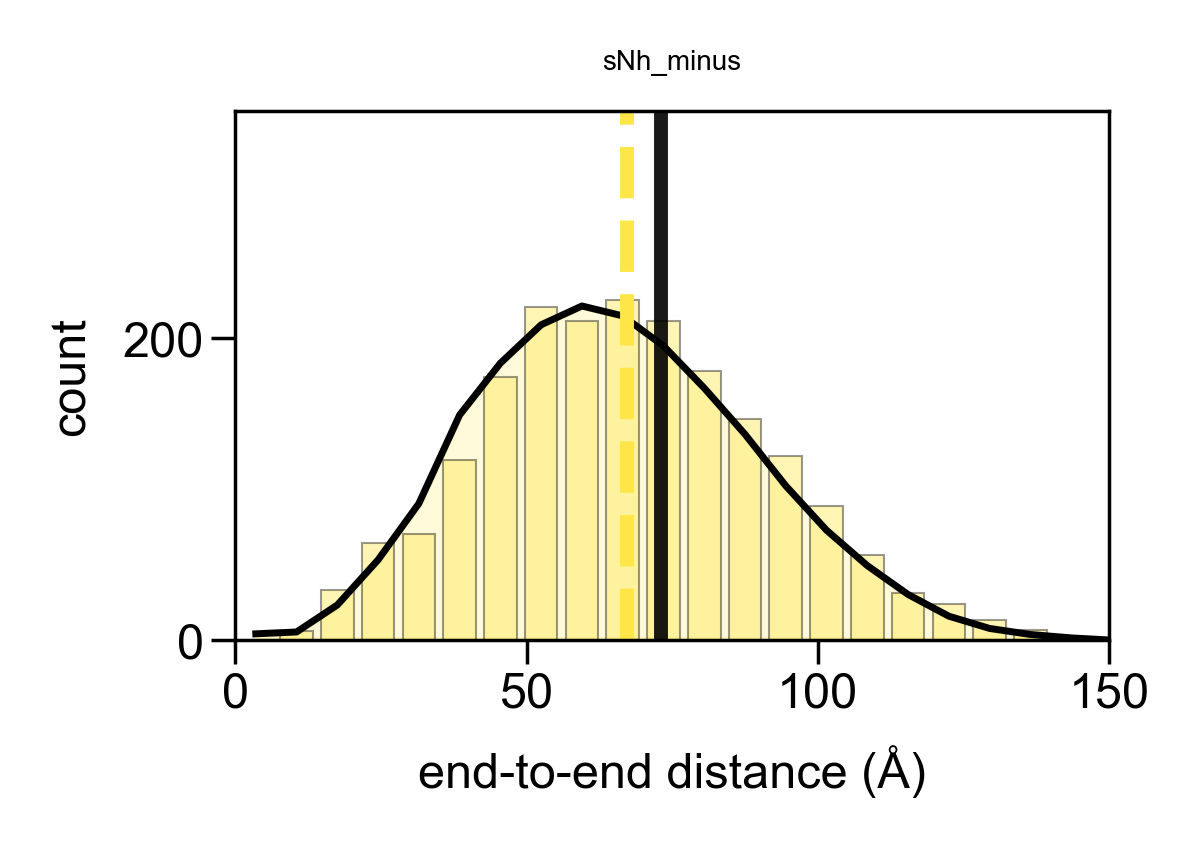

In [9]:
def get_histogram_vals(vals, bw=7, bmin=0,bmax=200, wl=10, polyorder=3):
    
    bins = np.arange(bmin,bmax,bw)
    [a,b]= np.histogram(vals,bins=bins)
    
    smoothed = savgol_filter(a,wl,polyorder)

    smoothed[smoothed<0]=0
    return b[1:]-bw*0.5, a, smoothed

def plot_histo(n, fn, color):        
    figure(None, (2.5,1.8), dpi=250)
    ax = plt.gca()
    X = get_histogram_vals(starling_res_all[n])
    plt.plot(X[0],X[2], color='k', lw=1)
    plt.fill_between(X[0], 0, X[2], alpha=0.2, color=color)
    plt.bar(X[0],X[1], width=7*0.8, color=color,alpha=0.4, edgecolor='k',lw=0.3)
    plt.ylim([0,350])
    plt.xlim([0,150])
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.ylabel('count', fontsize=7)
    plt.xlabel('end-to-end distance (Å)', fontsize=7)
    plt.title(n, fontsize=4)
    ax.axvline(new_vals[n]*10, color='k',lw=2, alpha=0.9)
    ax.axvline(np.mean(starling_res_all[n]), color=color,lw=2, alpha=1,ls='--')
    
    plt.tight_layout()
    plt.savefig(fn)

for n in starling_res_all:    
    plot_histo(n,'figures/'+n+'.pdf', schuler_colors[n])
    
    

In [10]:
diffs = []
for n in starling_res_all:    
    diffs.append(np.mean(starling_res_all[n]) - new_vals[n]*10)

In [11]:
RMSE = np.sqrt(np.mean(np.power(diffs,2)))
print(f"RMSE: {round(RMSE,2)} Å")

RMSE: 6.690000057220459 Å


In [12]:
for k in starling_res_all:
    print(f">{k}")
    Protein(seqs[k]).show_sequence(blocksize=100, newline=100)
    

>sGrich


>dKh


>dGrich


>sPTBP


>sCh


>sNrich


>sKh


>dCh_plus


>dCh_minus


>sKl


>sNh_plus


>dArich


>dErich


>dTRBP


>dKl


>sNh_minus
